In [133]:
import os
import shutil


dst_path = r"/kaggle/working/"
shutil.copy(r"/kaggle/input/aaabbb/utilities.py", dst_path)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py
/kaggle/input/utilities/utilities.py
/kaggle/input/preproc1/df_preproc.pkl
/kaggle/input/aaabbb/utilities.py


In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as u
import numpy as np
import importlib
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, InputLayer, Reshape, Normalization
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


importlib.reload(u)

plt.rcParams['figure.figsize'] = [12, 5]

In [ ]:
df = pd.read_parquet('/kaggle/input/preproc1/df_preproc.pkl')
df = df[df['wap'].notna()]
df_copy=df.copy()

In [ ]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result


inspect_columns(df)

In [ ]:
df['ask_size'].hist(bins=100, range=[0, 100_000])

In [ ]:
df['imbalance_size_signed'].hist(bins=100, range=[-10000_000, 10000_000])

In [ ]:
def show_hists(df, cols = None):
    if cols is not None:
        df = df[cols]
    # Calculating the number of rows and columns needed for subplots
    num_cols = len(df.columns)
    plot_cols = 3
    num_rows = (num_cols // plot_cols) + 1 # Ensures proper layout for odd number of columns

    # Creating subplots
    fig, axes = plt.subplots(num_rows, plot_cols, figsize=(12, 20))  # Adjust figsize as needed

    # Flatten axes if more than one row
    axes = axes.flatten()

    # Plotting each column in a separate subplot
    for i, col in enumerate(df.columns):
        df[col].hist(ax=axes[i], bins=100)
        axes[i].set_title(col)  # Setting Y-axis label

    # Hiding any unused subplots
    for i in range(num_cols, len(axes)):
        axes[i].axis('off')

    # Adjusting layout
    plt.tight_layout()
    plt.show()
show_hists(df, ['reference_price', 'matched_size', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'index', 'target'])

In [ ]:
def symmetric_range(data, percentile):
    # Calculate percentiles
    lower_bound = np.percentile(data.dropna(), percentile/2)
    upper_bound = np.percentile(data.dropna(), 100-(percentile/2))

    # Display ranges
    return lower_bound, upper_bound

def outlier_info(df, col):
    p = 3
    print(f"{'='*10} {col} {'='*10}")
    print(f"std: " + str(round(df[col].std(), p)))
    print(f"mean: " + str(round(df[col].mean(), p)))
    print(f"median: " + str(round(df[col].median(), p)))
    print(f"skew: " + str(round(df[col].skew(), p)))
    print(f"kurtosis: " + str(round(df[col].kurtosis(), p)))
    print(f"{'='*2} range {'='*2}")
    for c in [0, 1, 5, 12.5, 25]:
        l, u = symmetric_range(df[col], c)
        print(f"{100-c}%\t{round(l, p)}\t—  {round(u, p)}")
    print("\n\n")

def replace_outliers_by_critical(col, bottom_val, top_val):
    cnt = ((col < bottom_val) | (col > top_val)).sum()
    print(f"updates values: {cnt}")
    col.loc[col < bottom_val] = bottom_val
    col.loc[col > top_val] = top_val
    return col

    
outlier_info(df, 'wap')

In [ ]:
df['wap'] = replace_outliers_by_critical(df['wap'].copy(), -79, 86)

In [ ]:
outlier_info(df, 'index')

In [ ]:
outlier_info(df, 'reference_price')
df['reference_price'] = replace_outliers_by_critical(df['reference_price'].copy(), -79, 87)

In [ ]:
outlier_info(df, 'far_price')
df['far_price'] = replace_outliers_by_critical(df['far_price'].copy(), -700, 700)

In [ ]:
outlier_info(df, 'near_price')
df['near_price'] = replace_outliers_by_critical(df['near_price'].copy(), -500, 500)

In [ ]:
outlier_info(df, 'bid_price')
df['bid_price'] = replace_outliers_by_critical(df['bid_price'].copy(), -83, 81)

In [ ]:
outlier_info(df, 'ask_price')
df['ask_price'] = replace_outliers_by_critical(df['ask_price'].copy(), -75, 90)

In [ ]:
outlier_info(df, 'bid_size')

In [ ]:
df['bid_size'] = df['bid_size'].astype(float)
df['bid_size'], bid_size_lambda = stats.boxcox(df['bid_size'] + 1)  # Adding 1 to handle zeros
outlier_info(df, 'bid_size')
df['bid_size'].hist(bins=100)

In [ ]:
outlier_info(df, 'ask_size')
df['ask_size'] = df['ask_size'].astype(float)
df['ask_size'], ask_size_lambda = stats.boxcox(df['ask_size'] + 1)  # Adding 1 to handle zeros
outlier_info(df, 'ask_size')

In [ ]:
outlier_info(df, 'imbalance_size')
df['imbalance_size'] = df['imbalance_size'].astype(float)
df['imbalance_size_log'] = np.log(df['imbalance_size'] + 1)
outlier_info(df, 'imbalance_size_log')
df['imbalance_size_log'].hist(bins=100)

In [ ]:
df['imbalance_size_log_signed'] = df['imbalance_size_log'] * df['imbalance_buy_sell_flag']

In [ ]:
df['matched_size'] = df_copy['matched_size'].copy()
df['matched_size'] = df['matched_size'].astype(float)

In [ ]:
df['matched_size'] = np.log(np.log(df['matched_size'] + 1)) # Adding 1 to handle zeros
outlier_info(df, 'matched_size')
pd.Series(df['matched_size']).hist(bins=100)

In [ ]:
def normalize_target(target):
    abs_vals = np.abs(target)
    sign = np.array([1 if x > 0 else -1 for x in target])
    normalized = np.log(abs_vals + 1)
    res = normalized * sign
    return res

def inverse_normalize_target(target):
    sign = np.array([1 if x > 0 else -1 for x in target])
    abs_vals = np.abs(target)
    inversed = np.exp(abs_vals) - 1
    return inversed * sign
    
# df['target'] = normalize_target(df['target'])
df['target'] = df_copy['target'].copy()
df['target'].hist(bins=100)

In [ ]:
# X_cols = ['reference_price', 'matched_size', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'index', 'imbalance_size_log', 'imbalance_size_log_signed']
X_cols =  ['reference_price', 'matched_size', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

In [ ]:
show_hists(df, X_cols + ['target'])

In [115]:
num_stocks = df["stock_id"].nunique()
num_dates = df["date_id"].nunique()
num_updates = df["seconds_in_bucket"].nunique()-6

X = np.empty((num_stocks, num_dates, num_updates, len(X_cols)))
y = np.empty((num_stocks, num_dates, num_updates))
y_target = np.empty((num_stocks, num_dates, num_updates))
wap_current = np.empty((num_stocks, num_dates, num_updates))
cnt = 0
for (date_id, stock_id), frame in tqdm(df.groupby(['date_id', 'stock_id'])):
    X[stock_id, date_id] = frame[X_cols][:-6]
    y[stock_id, date_id] = frame['wap'][6:]
    y_target[stock_id, date_id] = frame['target'][:-6]
    wap_current[stock_id, date_id] = frame['wap'][:-6]
X_backup = X.copy()
y_backup = y.copy()

  0%|          | 0/95232 [00:00<?, ?it/s]

In [118]:

def r_x(X):
    return X.reshape(-1, num_updates, len(X_cols))
    

def r_y(y):
    return y.reshape(-1, num_updates)


def train_val_test_split(X, y, y_target, wap_current, train_split = .7, val_split = .1):
    i_train = int(num_dates * train_split)
    i_val = int(num_dates * val_split + i_train)

    X_train, X_val, X_test = X[:, :i_train], X[:, i_train:i_val], X[:, i_val:]
    y_train, y_val, y_test = y[:, :i_train], y[:, i_train:i_val], y[:, i_val:]
    y_target_test = y_target[:, i_val:]
    wap_current_test = wap_current[:, i_val:]

    return r_x(X_train), r_x(X_val), r_x(X_test), r_y(y_train), r_y(y_val), r_y(y_test), y_target_test, wap_current_test

X_train, X_val, X_test, y_train, y_val, y_test, y_target_test, wap_current_test = train_val_test_split(X, y, y_target, wap_current)

In [83]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, len(X_cols))).reshape(X_train.shape)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, len(X_cols))).reshape(X_val.shape)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, len(X_cols))).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
X_train_scaled.shape, y_train_scaled.shape, X_train_scaled.max()

((67200, 49, 7), (67200, 49), 8.41609588055483)

Xs



MEAN -1.1497120068421447e-17 
VAR 0.9999999999993039 
MIN -3.306531750262391 
MAX 3.693739995910344


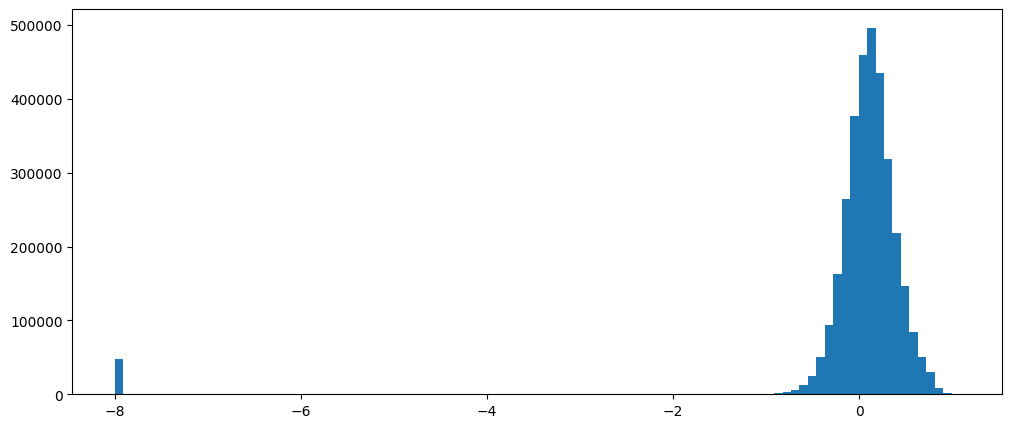


MEAN -7.540443855103978e-13 
VAR 1.0000000000011264 
MIN -8.005835105443513 
MAX 1.085132260892598



MEAN 1.4785710718623076e-17 
VAR 0.9999999999995346 
MIN -3.406129357012968 
MAX 3.6050252956817586



MEAN -3.392400322430231e-13 
VAR 1.0000000000007783 
MIN -3.2325514936355146 
MAX 7.414840741334766


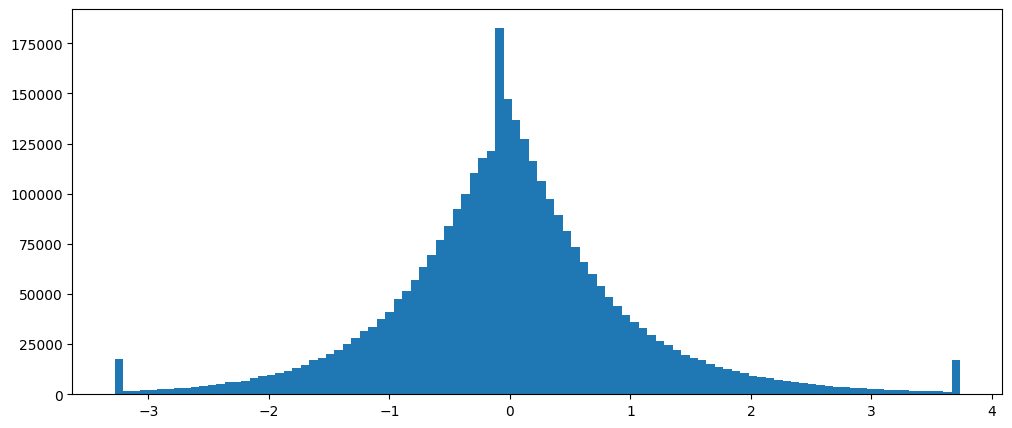


MEAN -1.802251253968767e-17 
VAR 1.0000000000009255 
MIN -3.280064890321727 
MAX 3.7356788697999397



MEAN 7.135423447437171e-14 
VAR 1.0000000000007885 
MIN -3.2480224221828076 
MAX 8.41609588055483



MEAN -2.3477602542121872e-18 
VAR 1.0000000000008629 
MIN -3.3433485329702424 
MAX 3.695254227873289
Y


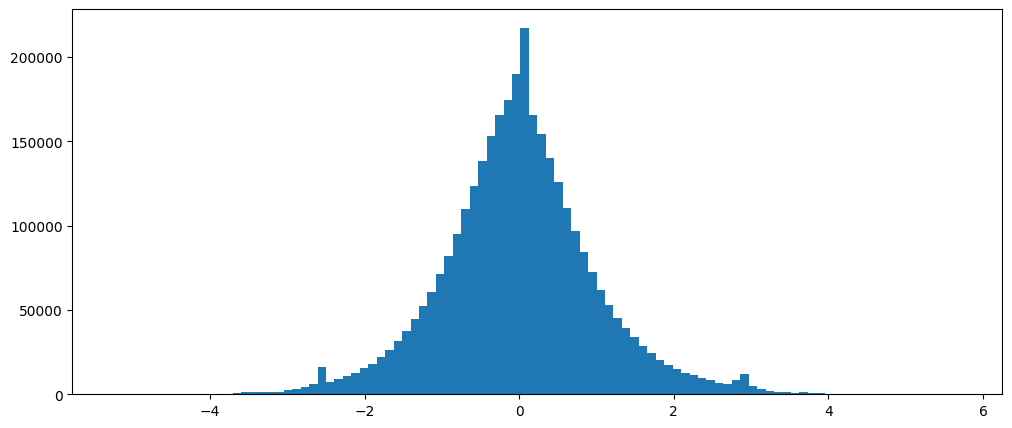


MEAN 4.6955205084243744e-18 
VAR 1.0000000000000024 
MIN -5.2328890104312 
MAX 5.702145721669437


In [84]:
print("Xs")
for i in range(X.shape[-1]):
    plt.hist(x=X_train_scaled[:, :, i].reshape(-1), bins=100)
    plt.show()
    print("\nMEAN", X_train_scaled[:, :, i].mean(),"\nVAR", X_train_scaled[:, :, i].var(), "\nMIN",X_train_scaled[:, :, i].min(), "\nMAX",X_train_scaled[:, :, i].max())
    
print("Y")
plt.hist(x=y_train_scaled.reshape(-1), bins=100)
plt.show()
print("\nMEAN", y_train_scaled.mean(),"\nVAR", y_train_scaled.var(), "\nMIN",y_train_scaled.min(), "\nMAX",y_train_scaled.max())

In [95]:
from tensorflow.keras.metrics import R2Score
from sklearn.metrics import r2_score
import tensorflow as tf


mask_val = np.finfo(np.float32).min
n_features = len(X_cols)

learning_rate = 0.1
time_steps = 55-6

hidden_units = [128, 128, 128]
dropout_rates = [0.3, 0.3, 0.3]

input_continuous = tf.keras.layers.Input(shape=(time_steps, n_features))
x = input_continuous

for i in range(len(hidden_units)):
    x = tf.keras.layers.LSTM(hidden_units[i], 
                             activation='tanh',
                             recurrent_activation='sigmoid',
                             return_sequences=True, 
#                              kernel_regularizer=l2(0.1), 
#                              recurrent_regularizer=l2(.1),
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=.1),
                             recurrent_constraint=tf.keras.constraints.MinMaxNorm(min_value=.1)
                            )(x)
    x = tf.keras.layers.Dropout(dropout_rates[i])(x)
    x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
    
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x) 
# out = tf.keras.layers.Dense(1)(x) 
model = tf.keras.models.Model(inputs=input_continuous, outputs=out)
huber_loss = tf.keras.losses.Huber(delta=1.0)

model.compile(optimizer=tf.keras.optimizers.Adam(), #
              loss='mse',
              metrics=['mean_absolute_error'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 49, 7)]           0         
                                                                 
 lstm_15 (LSTM)              (None, 49, 128)           69632     
                                                                 
 dropout_15 (Dropout)        (None, 49, 128)           0         
                                                                 
 batch_normalization_15 (Ba  (None, 49, 128)           512       
 tchNormalization)                                               
                                                                 
 lstm_16 (LSTM)              (None, 49, 128)           131584    
                                                                 
 dropout_16 (Dropout)        (None, 49, 128)           0         
                                                           

In [96]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=2, verbose=0, min_delta=1e-3, mode='min')
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=4, mode='min', restore_best_weights=True, verbose=0)
history = model.fit(X_train_scaled, y_train_scaled, 
          batch_size = 64,
          epochs = 30,
          validation_data = (X_val_scaled, y_val_scaled),
          callbacks = [rlr, es]
                   )


Epoch 1/30
1050/1050 [==============================] - 39s 27ms/step - loss: 0.4322 - mean_absolute_error: 0.4679 - val_loss: 0.2075 - val_mean_absolute_error: 0.3132 - lr: 0.0010
Epoch 2/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.2700 - mean_absolute_error: 0.3655 - val_loss: 0.2069 - val_mean_absolute_error: 0.3139 - lr: 0.0010
Epoch 3/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.2628 - mean_absolute_error: 0.3601 - val_loss: 0.2048 - val_mean_absolute_error: 0.3126 - lr: 0.0010
Epoch 4/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.2524 - mean_absolute_error: 0.3515 - val_loss: 0.2023 - val_mean_absolute_error: 0.3084 - lr: 1.0000e-04
Epoch 5/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.2508 - mean_absolute_error: 0.3502 - val_loss: 0.2014 - val_mean_absolute_error: 0.3073 - lr: 1.0000e-04
Epoch 6/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.2499 - 

In [97]:
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.reshape(y_test.shape)
y_pred = y_scaler.inverse_transform(y_pred)


607/607 [==============================] - 7s 9ms/step


In [98]:
y_pred = y_pred.reshape(y_test.shape)
mean_absolute_error(y_test, y_pred), mean_absolute_error(y_test, np.zeros_like(y_test)) # 6.8 with 3 layers and clipping to min=.1

(6.902726885102225, 15.77303110529392)

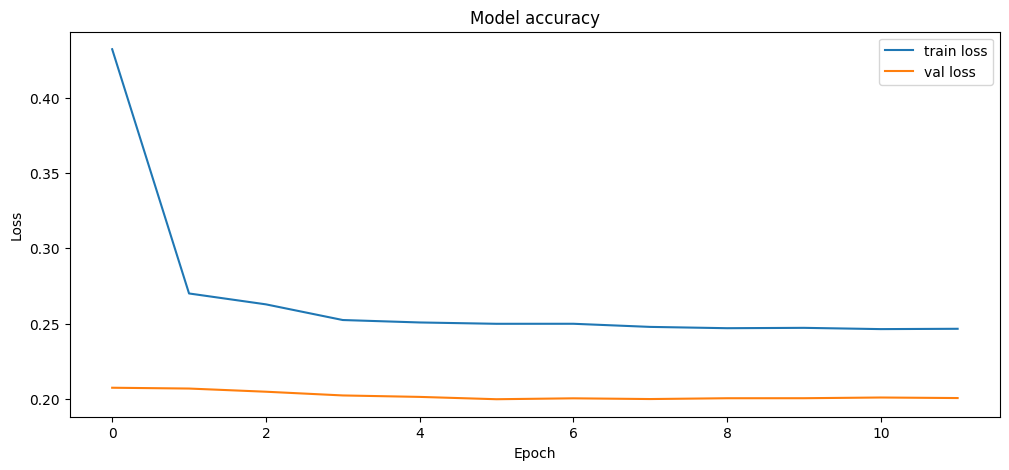

In [100]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

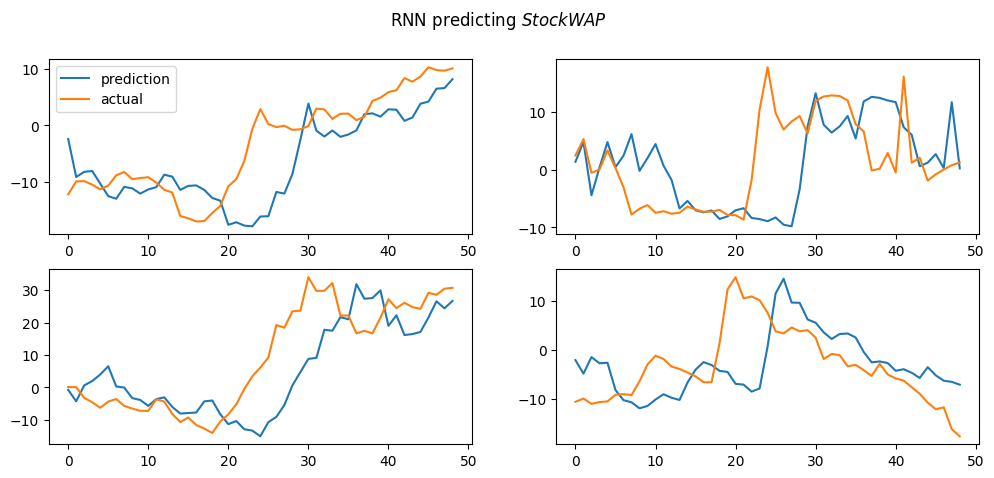

In [167]:
rows = 2
cols = 2

figure, axs = plt.subplots(nrows=rows, ncols=cols)
for row in range(rows):
    for col in range(cols):
        sample = row * cols + col
        ax = axs[row][col]
        ax.plot(y_pred[sample], label="prediction")
        ax.plot(y_test[sample], label="actual")
        if sample == 0:
            ax.legend()
        figure.suptitle('RNN predicting $StockWAP$')
plt.show()